Weakly coupled Co-simulation
================

This guides shows how to implement a simplified weakly-coupled co-simulation in emtsim

Test circuit
--------------------

As a first simple, test we will simulate a small static network. The network consists of 4 nodes and 4 elements:

| Component | Type              | Python Class                              | Node A | Node B | Paramter |
| :---------| :----             | :---------------------------------------- | :----- | :----- | :------- |
| r_1       | Source resistance | `dpsimpy.emt.ph1.Resistor`                 | 0      | GND    | 0.1 Ohm  |
| c_1       | Line capacitance  | `dpsimpy.emt.ph1.Capacitor`                | 0      | GND    | 1 Farad  |
| c_2       | Line capacitance  | `dpsimpy.emt.ph1.Capacitor`                | 1      | GND    | 1 Farad  |
| r_line    | Line resistance   | `dpsimpy.emt.ph1.Resistor`                 | 1      | 0      | 0.1 Ohm  |
| r_load    | Load              | `dpsimpy.emt.ph1.Resistor`                 | 1      | GND    | 1 Ohm    |

Before we can start, we must import the DPsim Python module.
We also add `emt` as an alias for the dynamic phasor components.

In [1]:
import dpsimpy

Next, we can define the model by creating a couple of components.
Each component is identified by a name which is passed as the first argument.
Following arguments are used to define the topology by assigning the component to a specific node / bus or to pass parameters.

In [2]:
# Nodes
gnd = dpsimpy.emt.SimNode.gnd
n1  = dpsimpy.emt.SimNode("n1")
n2  = dpsimpy.emt.SimNode("n2")

r_1 = dpsimpy.emt.ph1.Resistor("r_1")
r_1.R = 0.1
r_line = dpsimpy.emt.ph1.Resistor("r_line")
r_line.R = 0.1
c_1 = dpsimpy.emt.ph1.Capacitor("c_1")
c_1.C = 1
c_2 = dpsimpy.emt.ph1.Capacitor("c_2")
c_2.C = 1
r_load = dpsimpy.emt.ph1.Resistor("r_load")
r_load.R = 1

# Initial conditions
n1.set_initial_voltage(5)
n2.set_initial_voltage(2)

# Connections 
r_1.connect([n1, gnd])
r_line.connect([n1, n2])
c_1.connect([n1, gnd])
c_2.connect([n2, gnd])
r_load.connect([n2, gnd])

Next, we have to create a simulation object:

In [3]:
sys = dpsimpy.SystemTopology(50, [ gnd, n1, n2 ], [ r_1, r_line, c_1, c_2, r_load ])

We can also visualize the system topology:

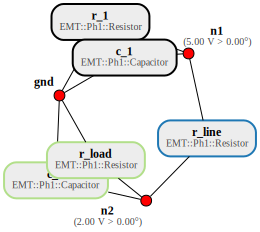

In [4]:
sys

Finally, we can start the simulation and wait for its completion:

In [5]:
time_step = 1e-6
final_time = 1.0

sim = dpsimpy.Simulation("EMTCosim", loglevel=dpsimpy.LogLevel.debug)
sim.set_domain(dpsimpy.Domain.EMT)
sim.set_system(sys)
sim.set_time_step(time_step)
sim.set_final_time(final_time)

log = dpsimpy.Logger("EMTCosim")
for i in range(1, len(sys.nodes)):
    log.log_attribute("v" + str(i), "v", sys.nodes[i])

sim.add_logger(log)
    
sim.run()

[07:52:58.353939 EMTCosim info] Initialize simulation: EMTCosim
[07:52:58.354170 MnaSolverFactory info] creating KLUAdapter solver implementation
[07:52:58.354817 EMTCosim info] Scheduling tasks.
[07:52:58.355182 EMTCosim info] Scheduling done.
[07:52:58.355185 EMTCosim info] Opening interfaces.
[07:52:58.355188 EMTCosim info] Start synchronization with remotes on interfaces
[07:52:58.355190 EMTCosim info] Synchronized simulation start with remotes
[07:52:58.355193 EMTCosim info] Start simulation: EMTCosim
[07:52:58.355200 EMTCosim info] Time step: 1.000000e-06
[07:52:58.355204 EMTCosim info] Final time: 1.000000e+00
[07:53:08.913325 EMTCosim info] Simulation calculation time: 10.558085
[07:53:08.980948 EMTCosim info] Simulation finished.


Next, we run the co-simulation

In [6]:
import subprocess
import numpy as np

H_v = np.array([1e-4, 0.001, 0.01])
H_v_legends = ['1e-4', '1e-3', '1e-2']

i=0
for H in H_v:
    subprocess.run(["python3", "../Python/Attributes/emt-cosim-attributes_polynomial.py", "-t", str(time_step), "-e", "1", "-H", str(H), "-p", "EMTCosimAttributes_zoh_" + H_v_legends[i]], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    subprocess.run(["python3", "../Python/Attributes/emt-cosim-attributes_polynomial.py", "-t", str(time_step), "-e", "1", "-H", str(H), "-i", "linear", "-p", "EMTCosimAttributes_linear_" + H_v_legends[i]], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    i+=1

# TODO: Verify why the villas co-simulation does not log outputs correctly using Popen
# process = subprocess.Popen(["python3", "../villas/emt-cosim-villas.py"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

Results can be analyzed and plotted by the `villas.dataprocessing` package:

column number: 2
results length: 1000000
real column names: ['v1', 'v2']
complex column names: []
column number: 4
results length: 1000000
real column names: ['i', 'ir', 'v1', 'v2']
complex column names: []
column number: 4
results length: 1000000
real column names: ['i', 'ir', 'v1', 'v2']
complex column names: []
column number: 4
results length: 1000000
real column names: ['i', 'ir', 'v1', 'v2']
complex column names: []
column number: 4
results length: 1000000
real column names: ['i', 'ir', 'v1', 'v2']
complex column names: []
column number: 4
results length: 1000000
real column names: ['i', 'ir', 'v1', 'v2']
complex column names: []
column number: 4
results length: 1000000
real column names: ['i', 'ir', 'v1', 'v2']
complex column names: []
column number: 5
results length: 1000
real column names: ['i', 'ir', 'v1', 'v2_S1']
complex column names: ['V_ref']


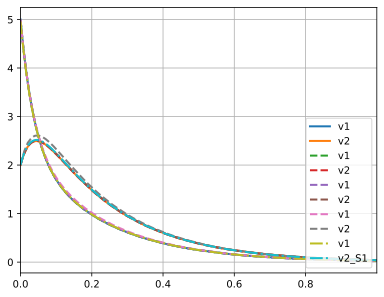

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc = {'font.size': 10, 'figure.figsize': (6.0, 4.0), 'figure.facecolor': 'white', 'savefig.dpi': 72, 'figure.subplot.bottom': 0.125, 'figure.edgecolor': 'white'}

import matplotlib.pyplot as plt
import villas.dataprocessing.plottools as pt
import villas.dataprocessing.readtools as rt
import villas.dataprocessing.timeseries as ts

results = rt.read_timeseries_dpsim('logs/EMTCosim.csv')

results_emt = []
for series in results:
    results_emt.append(results[series])

results_attributes_zoh = {}
for H_v_leg in H_v_legends:
    results_attributes_zoh[H_v_leg] = rt.read_timeseries_dpsim('logs/EMTCosimAttributes_zoh_' + H_v_leg + '_S1/S1.csv')
    
results_attributes_linear = {}
for H_v_leg in H_v_legends:
    results_attributes_linear[H_v_leg] = rt.read_timeseries_dpsim('logs/EMTCosimAttributes_linear_' + H_v_leg + '_S1/S1.csv')

# Get logs, if the co-simulation was executed from this script
# results_villas1 = rt.read_timeseries_dpsim('logs/EMTCosimVILLAS1/EMTCosimVILLAS1.csv')
# results_villas2 = rt.read_timeseries_dpsim('logs/EMTCosimVILLAS2/EMTCosimVILLAS2.csv')

# If the villas co-simulation was not executed from this script, read the logs as follows
# This assumes that you executed the script examples/villas/emt-cosim-villas.py previously
# results_villas1 = rt.read_timeseries_dpsim('../../logs/EMTCosimVILLAS1/EMTCosimVILLAS1.csv')
# results_villas2 = rt.read_timeseries_dpsim('../../logs/EMTCosimVILLAS2/EMTCosimVILLAS2.csv')

# Get logs from the co-simulation with Matlab
results_matlab = rt.read_timeseries_dpsim('logs/EMTCosimUDP1/EMTCosimUDP1.csv')

results_emt_matlab = []
for series in results_matlab:
    results_emt_matlab.append(results_matlab[series])

results_emt_attributes_zoh = {}

for k, results_att_list in results_attributes_zoh.items():
    results_emt_attributes_zoh[k] = []
    for series in results_att_list:
        results_emt_attributes_zoh[k].append(results_att_list[series])
        
results_emt_attributes_linear = {}

for k, results_att_list in results_attributes_linear.items():
    results_emt_attributes_linear[k] = []
    for series in results_att_list:
        results_emt_attributes_linear[k].append(results_att_list[series])
    
# results_emt_villas_1 = []
# for series in results_villas1:
#     results_emt_villas_1.append(results_villas1[series])
    
# results_emt_villas_2 = []
# for series in results_villas2:
#     results_emt_villas_2.append(results_villas2[series])

for series in results_emt:
    pt.plot_timeseries('Co-simulation results', series)

for k, results_att_list in results_emt_attributes_zoh.items():
    pt.plot_timeseries('Co-simulation results', results_att_list[2], '--')
    pt.plot_timeseries('Co-simulation results', results_att_list[3], '--')
    
# pt.plot_timeseries('Co-simulation results', results_emt_villas_1[3], '--')
# pt.plot_timeseries('Co-simulation results', results_emt_villas_1[4], '--')
# pt.plot_timeseries('Co-simulation results', results_emt_villas_2[2], '--')

pt.plot_timeseries('Co-simulation results', results_emt_matlab[3], '-.')
pt.plot_timeseries('Co-simulation results', results_emt_matlab[4], '-.')

plt.grid()
plt.show()

## Obtain the co-simulation errors

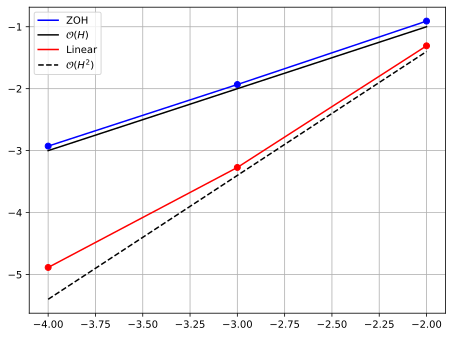

In [8]:
global_error_zoh = []
global_error_linear = []

for i in range(0, len(H_v_legends)):    
    H = H_v[i]
    
    m = int(H/time_step)
    
    ts_1_m = results_emt[0]
    ts_2_m = results_emt[1]
    
    ts_1_zoh = results_emt_attributes_zoh[H_v_legends[i]][2]
    ts_2_zoh = results_emt_attributes_zoh[H_v_legends[i]][3]
    
    ts_1_linear = results_emt_attributes_linear[H_v_legends[i]][2]
    ts_2_linear = results_emt_attributes_linear[H_v_legends[i]][3]
    
    v_a = np.array([ts_1_m.values[::m], ts_2_m.values[::m]])
    v_zoh = np.array([ts_1_zoh.values[::m], ts_2_zoh.values[::m]])
    v_linear = np.array([ts_1_linear.values[::m], ts_2_linear.values[::m]])
    
    global_error_zoh.append(np.max(np.linalg.norm(v_a - v_zoh, axis=0)))
    global_error_linear.append(np.max(np.linalg.norm(v_a - v_linear, axis=0)))
    
plt.figure()
plt.plot(np.log10(H_v), np.log10(global_error_zoh), 'b', label='ZOH')
plt.plot(np.log10(H_v), np.log10(global_error_zoh), 'bo')
plt.plot(np.log10(H_v), np.log10(np.multiply(H_v, 10**1)), 'k', label=r'$\mathcal{O}(H)$')
plt.plot(np.log10(H_v), np.log10(global_error_linear), 'r', label='Linear')
plt.plot(np.log10(H_v), np.log10(global_error_linear), 'ro')
plt.plot(np.log10(H_v), np.log10(np.multiply(H_v**2, 10**2.6)), '--k', label=r'$\mathcal{O}(H^2)$')
plt.xlabel('')
# TODO: Fix log scale
# plt.xscale("log")
# plt.yscale("log")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()
    
    

In [9]:
!cat logs/EMTCosim.log

[I] Initialize simulation: EMTCosim
[I] Scheduling tasks.
[I] Scheduling done.
[I] Opening interfaces.
[I] Start synchronization with remotes on interfaces
[I] Synchronized simulation start with remotes
[I] Start simulation: EMTCosim
[I] Time step: 1.000000e-06
[I] Final time: 1.000000e+00
[I] Simulation calculation time: 10.558085
[I] Simulation finished.
